In [16]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
import shutil

In [30]:
def seg_skin(path):
    test_img = []
    for images in sorted(os.listdir(path), key = len):
        test_image = os.path.join(path, images)
        test_img.append(test_image)
    # 이미지 로드 및 그레이 이미지로 변경
    image = cv2.imread(test_img[0])
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # 이미지 노이즈 제거
    kernel1 = np.ones((5,5),np.float32)/25
    dst1 = cv2.filter2D(gray,-1,kernel1)

    #  threshold 이미지 필터 생성
    ret2, th2 = cv2.threshold(dst1, 45, 255,  cv2.THRESH_TRUNC+cv2.THRESH_OTSU) # cv2.THRESH_BINARY+cv2.THRESH_OTSU

    # 불규칙한 모양과 노이즈 제거
    kernel3 = np.ones((5,5), np.uint8) 
    img_erosion = cv2.erode(th2, kernel3, iterations=5)

    # 관심 영역에 대한 확장
    img_dilation = cv2.dilate(img_erosion, kernel3, iterations=5)

    contours, hierarchy = cv2.findContours(img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours) != 0:
        c = max(contours, key = cv2.contourArea)
        x,y,w,h = cv2.boundingRect(c)
        new_img = gray[y:y+h,x:x+w]

    median_filter = cv2.medianBlur(new_img, 5)

    kernel=cv2.getStructuringElement(cv2.MORPH_RECT,(9,9))
    erosion = cv2.morphologyEx(median_filter, cv2.MORPH_ERODE, kernel)
    dilation = cv2.morphologyEx(erosion, cv2.MORPH_DILATE, kernel)

    ret3,th3 = cv2.threshold(dilation,110,255,cv2.THRESH_BINARY)
    th3 = cv2.bitwise_not(th3)

    #  뇌종양일 경우 이미지위에 튜머 표시
    contours,hierarchy = cv2.findContours(th3, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    if len(contours) != 0:
        c = max(contours, key = cv2.contourArea)
        x,y,w,h = cv2.boundingRect(c)
        tumor = image[y:y+h,x:x+w]
        
        new_img = cv2.rectangle(image, (x, y), (x + w, y + h), (0,255,150), 1)
        # cv2.putText(new_img, 'Tumor Detected', (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)

    file_name = sorted(os.listdir(path), key = len)[0].split(".")[0]
    save_path = './sample_' + "/detected" 
    if os.path.isdir(save_path):
        shutil.rmtree(save_path) ## 있으면 지우기
    os.makedirs(save_path)     
    save_file = save_path + "/" + file_name + ".jpg"
    cv2.imwrite(save_file , th3)
    img = plt.imshow( th3) # 체크용, 나중에 삭제
    return (th3)

In [31]:
a ="./images/sample"

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

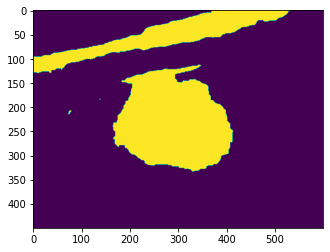

In [32]:
seg_skin(a)